In [1]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
import community

In [2]:
# import graph
G = nx.read_edgelist('trainEdges.txt', create_using=nx.Graph(), nodetype=int)
node, edge = G.order(), G.size()
print("No. of nodes are", node)
print("No. of edges are", edge)

No. of nodes are 36446
No. of edges are 231202


In [3]:
# add nodes from the original graph
allNodes = set()
with open("edges.txt", 'r') as f:
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
        allNodes.add(int(row[0]))
        allNodes.add(int(row[1]))
currNodes = set(G.nodes())
for node in allNodes:
    if node not in currNodes:
        G.add_node(node)
node, edge = G.order(), G.size()
print("No. of nodes are", node)
print("No. of edges are", edge)

No. of nodes are 37700
No. of edges are 231202


In [4]:
# load test set
with open("testEdgesWithLabel.txt", 'r') as f:
    reader = csv.reader(f, delimiter=' ')
    testEdges = [(int(row[0]), int(row[1]), int(row[2])) for row in reader]
testLabels = [e[2] for e in testEdges]
testEdges = [(e[0], e[1]) for e in testEdges]
print("Number of test points:", len(testEdges))

Number of test points: 115602


In [11]:
%%time
# resource_allocation_index
pred_resource_allocation = list(nx.resource_allocation_index(G, testEdges))

CPU times: user 48.2 s, sys: 163 ms, total: 48.4 s
Wall time: 48.5 s


In [12]:
len(pred_resource_allocation)
print(pred_resource_allocation[:10])

[(1, 14683, 0), (1, 34090, 0), (3, 7947, 0), (3, 18029, 0), (3, 30891, 0), (3, 34935, 0), (4, 2865, 0), (4, 23247, 0), (7, 1461, 0), (7, 21864, 0.00038284839203675346)]


In [13]:
%%time
pred_jaccard_coefficient = list(nx.resource_allocation_index(G, testEdges))

CPU times: user 47.4 s, sys: 79.9 ms, total: 47.5 s
Wall time: 47.6 s


In [18]:
# get error when using this algorithm
# pred_adamic_adar = list(nx.adamic_adar_index(G, testEdges))

In [15]:
%%time
pred_preferential_attachment = list(nx.preferential_attachment(G, testEdges))

CPU times: user 325 ms, sys: 10 ms, total: 335 ms
Wall time: 334 ms


In [5]:
%%time
# perform community deduction, link prediction algorithm below will need it
partition = community.best_partition(G)
for i in G.nodes():
    G.nodes[i]['community'] = partition[i]

In [6]:
%%time
pred_cn_soundarajan_hopcroft = list(nx.cn_soundarajan_hopcroft(G, testEdges))

CPU times: user 49.7 s, sys: 2.46 ms, total: 49.7 s
Wall time: 49.8 s


In [7]:
%%time
pred_ra_index_soundarajan_hopcroft = list(nx.ra_index_soundarajan_hopcroft(G, testEdges))

CPU times: user 13 s, sys: 3.27 ms, total: 13 s
Wall time: 13 s


In [8]:
%%time
pred_within_inter_cluster = list(nx.within_inter_cluster(G, testEdges))

CPU times: user 12.6 s, sys: 56.2 ms, total: 12.7 s
Wall time: 12.7 s


In [42]:
def evaluate(predictionLabels, testLabels):
    """
    Get the true positive rate and false positive rate given the prediction
    predictionLabels: list of predictions, either 1 or 0
    testLabels: list of ground truth, either 1 or 0
    return: True positive rate and false positive rate
    """
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(predictionLabels)):
        if predictionLabels[i] == 1:
            if testLabels[i] == 1:
                TP += 1
            else: 
                FP += 1
        else:
            if testLabels[i] == 1:
                FN += 1
            else: 
                TN += 1
    TPR = TP / (TP + FN)
    FPR = FP / (TN + FP)
    return TPR, FPR
    
def truePosVSFalsePos(predictions, testEdges, testLabels):
    """
    Using different threshold to get different true positive rate and flase positive rate
    predictions: list of tuple (node1, node2, prediction_score)
    testEdges: list of tuple(node1, node2)
    testLabels: list of label, either 0 or 1
    return: list of true positive rate and false positive rate, along with the AUC
    """
    allScore = [a[2] for a in predictions]
    allScore.sort()
    testNum = len(testLabels)
    truePos = []
    falsePos = []
    numOfPoints = 50
    for i in range(numOfPoints): 
        pred_result = []
        threshold = allScore[int(testNum / numOfPoints * i)]
        for edge in predictions:
            if edge[2] >= threshold:
                pred_result.append(1)
            else:
                pred_result.append(0)
        TPR, FPR = evaluate(pred_result, testLabels)
        truePos.append(TPR)
        falsePos.append(FPR)
    return truePos, falsePos, calcAUC(truePos, falsePos)

def calcAUC(truePos, falsePos):
    """
    Calculate the area under the ROC curve
    truePos: y index
    falsePos: x index
    return: area under the curve
    """
    truePos.sort()
    falsePos.sort()
    pre_x, pre_y, area = 0, 0, 0
    for i in range(len(truePos)):
        area += (pre_y + truePos[i])*(falsePos[i] - pre_x)*0.5
        pre_x, pre_y = falsePos[i], truePos[i]
    return '{0:.2f}'.format(area)
        

In [43]:
truePos_RA, falsePos_RA, AUC_RA = truePosVSFalsePos(pred_resource_allocation, testEdges, testLabels)
truePos_JC, falsePos_JC, AUC_JC = truePosVSFalsePos(pred_jaccard_coefficient, testEdges, testLabels)
truePos_PA, falsePos_PA, AUC_PA = truePosVSFalsePos(pred_preferential_attachment, testEdges, testLabels)
truePos_CSH, falsePos_CSH, AUC_CSH = truePosVSFalsePos(pred_cn_soundarajan_hopcroft, testEdges, testLabels)
truePos_RISH, falsePos_RISH, AUC_RISH = truePosVSFalsePos(pred_ra_index_soundarajan_hopcroft, testEdges, testLabels)
truePos_WIS, falsePos_WIS, AUC_WIS = truePosVSFalsePos(pred_within_inter_cluster, testEdges, testLabels)

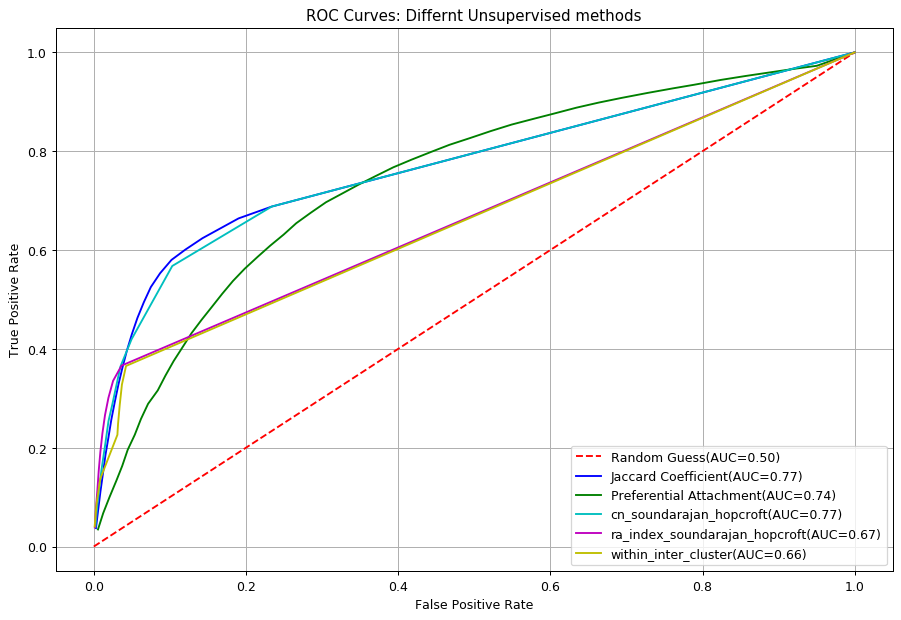

In [46]:
plt.figure(figsize=(12,8), dpi=90)

# plt.plot(falsePos_RA, truePos_RA, 'g-') RA has the same result as Jaccard coefficient
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess(AUC=0.50)')
plt.plot(falsePos_JC, truePos_JC, 'b-', label='Jaccard Coefficient(AUC={})'.format(AUC_JC))
plt.plot(falsePos_PA, truePos_PA, 'g-', label='Preferential Attachment(AUC={})'.format(AUC_PA))
plt.plot(falsePos_CSH, truePos_CSH, 'c-', label='cn_soundarajan_hopcroft(AUC={})'.format(AUC_CSH))
plt.plot(falsePos_RISH, truePos_RISH, 'm-', label='ra_index_soundarajan_hopcroft(AUC={})'.format(AUC_RISH))
plt.plot(falsePos_WIS, truePos_WIS, 'y-', label='within_inter_cluster(AUC={})'.format(AUC_WIS))
plt.legend(loc='lower right')
plt.grid()

plt.title('ROC Curves: Differnt Unsupervised methods')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()